In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sympy import *

In [ ]:
def T(a_arr, alpha_arr, d_arr, theta_arr):
    pose = np.identity(4)
    for i in range(len(theta_arr)):
        a, alpha, d, theta = a_arr[i], alpha_arr[i], d_arr[i], theta_arr[i]
        rot = np.matrix([
            [np.cos(theta), -np.sin(theta), 0, 0],
            [np.sin(theta),  np.cos(theta), 0, 0],
            [0            ,              0, 1, d],
            [0            ,              0, 0, 1],
        ])
        trans = np.matrix([
            [1,             0,              0, a],
            [0, np.cos(alpha), -np.sin(alpha), 0],
            [0, np.sin(alpha),  np.cos(alpha), 0],
            [0,             0,              0, 1],
        ])
        pose = np.matmul(pose, np.matmul(rot, trans))
    return pose

In [ ]:
def z(i_minus_1, theta_arr, alpha_arr): # returns z_{i-1}.
    #z_0 = np.array([[0,0,1]]).T
    if i_minus_1==0:
        return np.array([0,0,1]).T
    R = np.identity(3)
    for x in range(1, i_minus_1+1): # x in theta_arr:
        theta, alpha = theta_arr[x-1], alpha_arr[x-1]
        R_z = np.matrix([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [            0,              0, 1]
        ])
        R_x = np.matrix([
            [1,             0,              0],
            [0, np.cos(alpha), -np.sin(alpha)],
            [0, np.sin(alpha),  np.cos(alpha)],
        ])
        R = np.matmul(R, np.matmul(R_z, R_x))
    return np.asarray(R[:,2].T)[0].T # third column

In [ ]:
def p(i_minus_1, a_arr, alpha_arr, d_arr, theta_arr):
    a, alpha, d, theta = a_arr[:i_minus_1+1], alpha_arr[:i_minus_1+1], d_arr[:i_minus_1+1], theta_arr[:i_minus_1+1]
    #a, alpha, d, theta = a_arr[i_minus_1], alpha_arr[i_minus_1], d_arr[i_minus_1], theta_arr[i_minus_1]
    pose = T(a, alpha, d, theta)
    return np.asarray(pose[:3,-1].T)[0].T

In [ ]:
def jacobian(a_arr, alpha_arr, d_arr, theta_arr):
    I = len(theta_arr)
    p_e = p(I-1, a_arr, alpha_arr, d_arr, theta_arr)
    J = np.zeros(shape=(6,I))
    for i in range(I):
        z_i = z(i, theta_arr, alpha_arr)
        diff = p_e - p(i, a_arr, alpha_arr, d_arr, theta_arr)
        cp = np.cross(z_i.T, diff.T)
        col = np.concatenate((cp, z_i))
        J[:,i] = col
    return J

### IIK

In [2]:
def I(n):
    return Matrix(n, n, lambda i,j: 1 if i==j else 0)

In [95]:
x, b, a, d = symbols('x b a d')
Rot = Matrix([
    [cos(x), -sin(x), 0, 0],
    [sin(x),  cos(x), 0, 0],
    [     0,       0, 1, d],
    [     0,       0, 0, 1]
])
Trans = Matrix([
    [     1,      0,       0, a],
    [     0, cos(b), -sin(b), 0],
    [     0, sin(b),  cos(b), 0],
    [     0,      0,       0, 1]
])
A = Rot*Trans

In [96]:
global T
global Jp
global Jo

In [97]:
ks_a = Array([0, 0, 0, 0.0825, -0.0825, 0, 0.088, 0])
ks_b = Array([0, -pi/2, pi/2, pi/2, -pi/2, pi/2, pi/2, 0]) #alpha
ks_d = Array([0.333, 0, 0.316, 0, 0.384, 0, 0, 0.107])

# thetas
x1, x2, x3, x4, x5, x6, x7 = symbols('x1 x2 x3 x4 x5 x6 x7')
ks_x = Array([x1, x2, x3, x4, x5, x6, x7]) #theta1...theta7
Jo = Matrix([[0],[0],[1]]) #Matrix('ks_z', 3, 7) #[Matrix([[0],[0],[1]])]

T = I(n=4)
R = I(n=4)
for i, (k_a, k_b, k_d, k_x) in enumerate(zip(ks_a, ks_b, ks_d, ks_x)):
    Ap = A.replace(a, k_a).replace(b, k_b).replace(d, k_d).subs(x, k_x)
    T = T * Ap
    Jo = Jo.col_insert(i+1, T[:3,2])

In [98]:
Jp = T[:3,-1].jacobian(ks_x).evalf()
Jo.col_del(-1)
Jo = Jo.evalf()

In [100]:
# ):
def get_T(theta):
    #d_T = T.replace(x1, theta[0]).replace(x2, theta[1]).replace(x3, theta[2])\
    #.replace(x4, theta[3]).replace(x5, theta[4]).replace(x6, theta[5])\
    #.replace(x7, theta[6])
    return T.evalf(subs={
        x1: theta[0],
        x2: theta[1],
        x3: theta[2],
        x4: theta[3],
        x5: theta[4],
        x6: theta[5],
        x7: theta[6]
    })

In [101]:
def get_J(theta):
    #d_Jp = Jp.replace(x1, theta[0]).replace(x2, theta[1]).replace(x3, theta[2])\
    #.replace(x4, theta[3]).replace(x5, theta[4]).replace(x6, theta[5])\
    #.replace(x7, theta[6])
    #d_Jo = Jo.replace(x1, theta[0]).replace(x2, theta[1]).replace(x3, theta[2])\
    #.replace(x4, theta[3]).replace(x5, theta[4]).replace(x6, theta[5])\
    #.replace(x7, theta[6])
    d_Jp = Jp.evalf(subs={
        x1: theta[0],
        x2: theta[1],
        x3: theta[2],
        x4: theta[3],
        x5: theta[4],
        x6: theta[5],
        x7: theta[6]
    })
    d_Jo = Jo.evalf(subs={
        x1: theta[0],
        x2: theta[1],
        x3: theta[2],
        x4: theta[3],
        x5: theta[4],
        x6: theta[5],
        x7: theta[6]
    })
    
    n_Jp = np.asarray(d_Jp).astype(np.float64)
    n_Jo = np.asarray(d_Jo).astype(np.float64)
    J = np.vstack((n_Jp, n_Jo))
    return J

In [102]:
def J_inv(J_k, e):
    return np.linalg.pinv(J_k)

In [103]:
e = np.zeros(shape=(6,))
T_k = np.matrix([ # = T_i
    [0.515, 0.481, 0.709, -.0815],
    [0.476, -.849, 0.230, -.0409],
    [0.713, 0.219, -.667,  0.399],
    [    0,     0,      0,      1]
])
T_d = np.matrix([
    [-.781, -.474, 0.407, -.0206],
    [-.220, -.818, 0.531,  -.147],
    [-.585, 0.325, -.743,  0.620],
    [    0,     0,     0,       1]
])
q_k = [0.1, 0.2, 0.3, -0.4, 0.5, 0.6, 0.7]
K_p, K_o = 0.5, 0.15

In [ ]:
q_arr = []
e_arr = []
T_arr = []
e = np.array(np.inf)

#while (np.linalg.norm(e) > 0.1):
    #print np.linalg.norm(e)
    #q_k # TODO whack?

for i in range(112):
    print i
    T_k, J_k = get_T(q_k), get_J(q_k)
    
    e_p = T_d[:3,-1] - T_k[:3,-1]
    e_o = np.cross(T_k[:3,0].T, T_d[:3,0].T) +\
            np.cross(T_k[:3,1].T, T_d[:3,1].T) +\
            np.cross(T_k[:3,2].T, T_d[:3,2].T)    
    e = np.concatenate((K_p*np.asarray(e_p.T)[0], K_o*np.asarray(e_o)[0])).astype(float) # TODO check this
    e_arr.append(np.sum(e))

    delta_q_k = np.matmul(J_inv(J_k, e), e) #np.matmul(Jinv(J_k, e), e)
    q_k = q_k + delta_q_k
    q_arr.append(q_k)
    T_arr.append(np.asarray(T_k[:3,-1]).T[0].tolist())

0
1


In [ ]:
J = np.vstack((Jp, Jo))

In [ ]:
def get_J(q):
    a_arr = [0, 0, 0, 0.0825, -0.0825, 0, 0.088, 0]
    alpha_arr = [0, -pi/2, pi/2, pi/2, -pi/2, pi/2, pi/2, 0]
    d_arr = [0.333, 0, 0.316, 0, 0.384, 0, 0, 0.107]
    
    T = I(n=4)
    for (k_a, k_b, k_d) in zip(a_arr, alpha_arr, d_arr):
        A.subs(a, k_a); A.subs(b, k_b); A.subs(d, k_d)
        T = T * A
    return T

In [ ]:
a_arr = [0, 0, 0, 0.0825, -0.0825, 0, 0.088, 0]
alpha_arr = [0, -np.pi/2, np.pi/2, np.pi/2, -np.pi/2, np.pi/2, np.pi/2, 0]
d_arr = [0.333, 0, 0.316, 0, 0.384, 0, 0, 0.107]
theta_arr = [0.1, 0.2, 0.3, -0.4, 0.5, 0.6, 0.7]
J = jacobian(a_arr, alpha_arr, d_arr, theta_arr)

In [ ]:
np.gradient(theta_arr)

In [ ]:
J

In [ ]:
e = np.zeros(shape=(6,))
T_k = np.matrix([ # = T_i
    [0.515, 0.481, 0.709, -.0815],
    [0.476, -.849, 0.230, -.0409],
    [0.713, 0.219, -.667,  0.399],
    [    0,     0,      0,      1]
])
T_d = np.matrix([
    [-.781, -.474, 0.407, -.0206],
    [-.220, -.818, 0.531,  -.147],
    [-.585, 0.325, -.743,  0.620],
    [    0,     0,     0,       1]
])
q_k = [0.1, 0.2, 0.3, -0.4, 0.5, 0.6, 0.7]
K_p, K_o = 0.5, 0.15

In [ ]:
def J_inv(J, e):
    #JJte = np.matmul(np.matmul(J, J.T), e)
    #alpha = (JJte * e)/(JJte * JJte)
    #return alpha * J.T
    #return np.matmul(J.T, e)
    return np.linalg.pinv(J)

In [ ]:
q_arr = []
e_arr = []
T_arr = []
e = np.array(np.inf)
#for k in range(1000): # TODO convergence via norm
while (np.linalg.norm(e) > 0.1):
    #print np.linalg.norm(e)
    theta_arr = q_k # TODO whack?
    T_k = T(a_arr, alpha_arr, d_arr, theta_arr)
    J_k = jacobian(a_arr, alpha_arr, d_arr, theta_arr)
    
    e_p = T_d[:3,-1] - T_k[:3,-1]
    e_o = np.cross(T_k[:3,0].T, T_d[:3,0].T) +\
            np.cross(T_k[:3,1].T, T_d[:3,1].T) +\
            np.cross(T_k[:3,2].T, T_d[:3,2].T)    
    e = np.concatenate((K_p*np.asarray(e_p.T)[0], K_o*np.asarray(e_o)[0])) # TODO check this
    e_arr.append(np.sum(e))

    delta_q_k = np.matmul(J_inv(J, e), e) #np.matmul(Jinv(J_k, e), e)
    q_k = q_k + delta_q_k
    q_arr.append(q_k)
    T_arr.append(np.asarray(T_k[:3,-1]).T[0].tolist())

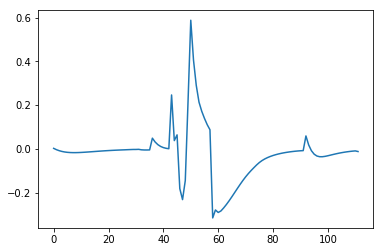

In [53]:
plt.plot(e_arr)
plt.show()

In [69]:
T_nd = np.array(T_arr).astype(float)

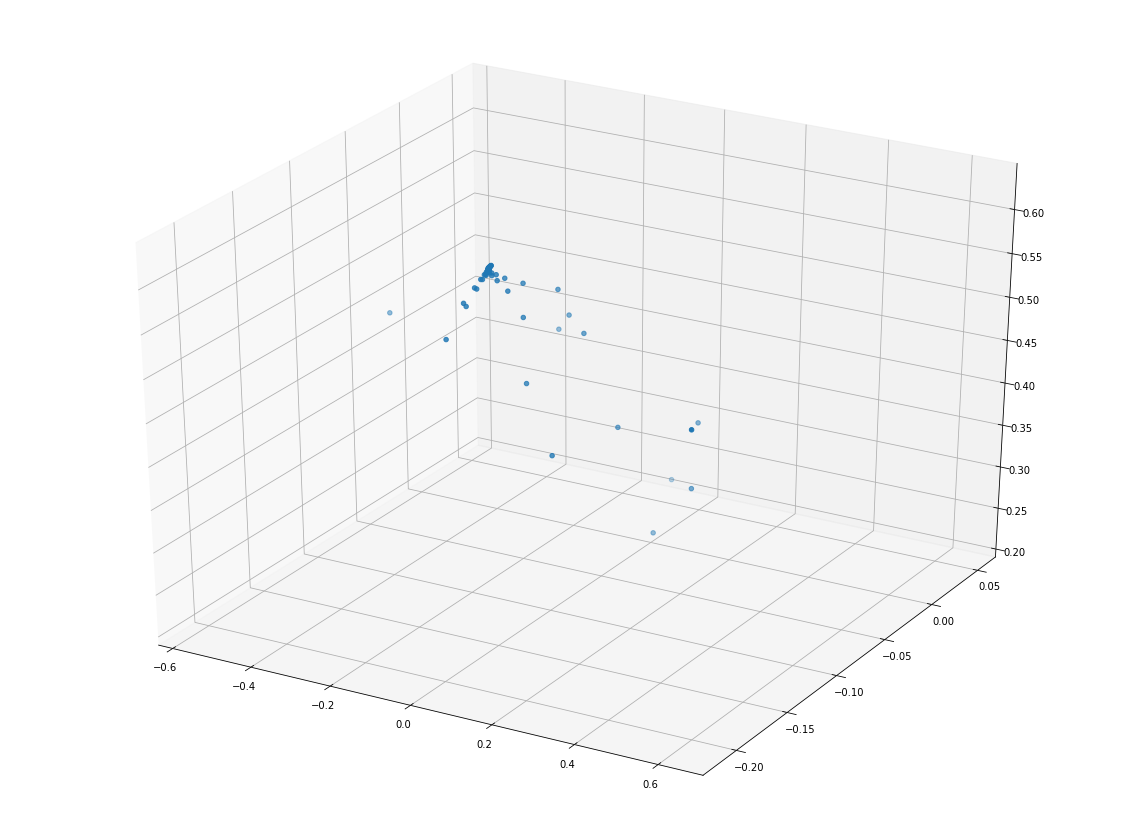

In [70]:
fig = plt.figure(figsize=(20,15))
#plt.plot(T_nd[:,2])
#plt.show()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T_nd[:,0], T_nd[:,1], T_nd[:,2])
plt.show()

In [ ]:
with open('q.csv', 'w') as f:
    for row in q_arr:
        n_row = ['{:.3f}'.format(n) for n in row.tolist()]
        f.write('%s\n' % ','.join(n_row))